## CLASSIFICAÇÃO IRIS EVALUATION

### PARAMETROS

In [253]:
# PARÂMETROS
random_seed = 42

# FEATURE SELECTION
center_stat = 'mean'

# KNN
k_min = 1
k_max = 11
distance_metric = 'euclidean'
weights = 'uniform'
holdout_size = 0.2
k_of_k_folds = 5

# GOURMET
palette = ['limegreen', 'indianred', 'gold']

# EVALUATION
evaluation_metrics = ['accuracy', 'precision', 'recall', 'f1_score']
evaluation_pick = 'recall'
evaluation_average = 'micro'

In [254]:
from typing import Optional

import numpy
import pandas
import seaborn
from matplotlib import pyplot
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             precision_score, recall_score, roc_auc_score)
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

### IMPORT IRIS

In [255]:
iris_dict = load_iris()
iris = pandas.DataFrame(iris_dict['data'])
iris.columns = iris_dict['feature_names']
iris.columns = ["sepal_length", "sepal_width", "petal_length", "petal_width"]
iris['target'] = iris_dict['target']
iris['species'] = iris['target'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})

iris

,sepal_length,sepal_width,petal_length,petal_width,target,species
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,virginica
146,6.3,2.5,5.0,1.9,2,virginica
147,6.5,3.0,5.2,2.0,2,virginica
148,6.2,3.4,5.4,2.3,2,virginica


### PAIRPLOT

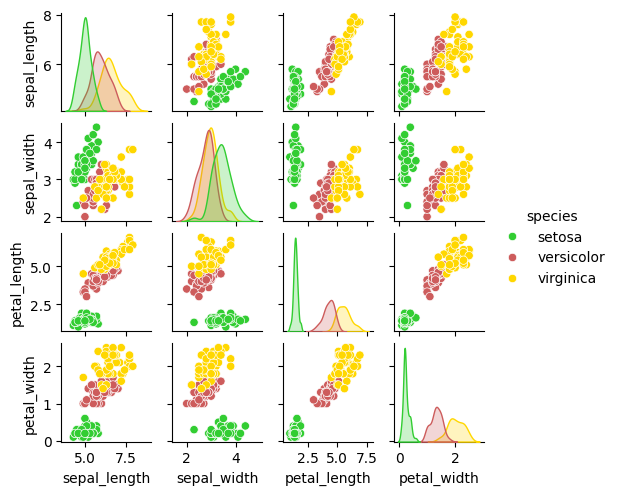

In [256]:
_ = seaborn.pairplot(iris[["sepal_length", "sepal_width", "petal_length", "petal_width", "species"]], hue='species', palette=palette, height=1.25)

### SELEÇÃO DO TOP 2 ATRIBUTOS

In [257]:
all_cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
centers = iris.groupby(['species'])[all_cols].agg(center_stat).T
max_diff = (centers.T.max() - centers.T.min()).sort_values(ascending=False)

max_diff

petal_length    4.090
petal_width     1.780
sepal_length    1.582
sepal_width     0.658
dtype: float64

In [258]:
x_cols_sorted = max_diff.index.tolist()[:2]

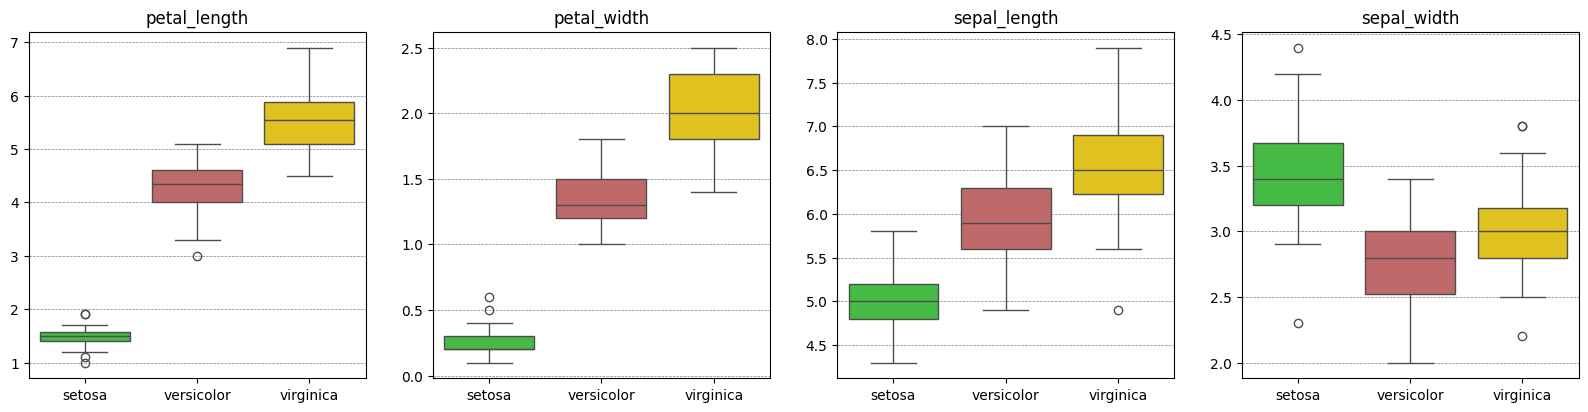

In [259]:
x_cols_sorted = max_diff.index.tolist()

# BOXPLOT DOS ATRIBUTOS VS CLASSE
fig, axs = pyplot.subplots(1, 4, figsize=(20, 4.5))
for i, ax in enumerate(axs.flatten()):
    seaborn.boxplot(x='species', y=x_cols_sorted[i], data=iris, ax=ax, hue='species', dodge=False, palette=palette)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(x_cols_sorted[i])
    ax.grid(which='both', axis='y', color='gray', linestyle='--', linewidth=0.5)

In [260]:
x_cols = x_cols_sorted[:2]

x_cols

['petal_length', 'petal_width']

### LOOP DE TREINAMENTO

> TRAINING SIZE VS KNN (MÚLTIPLOS KS) VS REGRESSÃO LOGÍSTICA

In [261]:
metrics_dict = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'f1_score': f1_score
}

In [262]:
# RANDOM SEED
numpy.random.seed(random_seed)

# SEPARAR 20% DOS DADOS COMO HOLDOUT
iris_train : Optional[pandas.DataFrame] = None
iris_test : Optional[pandas.DataFrame] = None
iris_train, iris_test = train_test_split(iris, test_size=holdout_size, stratify=iris['target'], random_state=random_seed)

# LOOP DE TREINAMENTO
ks = range(k_max, k_min - 2, -2)
database_size_range = numpy.arange(0.05, 1.05, 0.05)

# LOOP DE TREINO
# PARA TODOS OS Ks, PARA FEATURES DE 1 A 4 E PARA TODOS OS FOLDS
ix_model = 0
model_list = []
for db_size in database_size_range:
    if db_size != 1.0:
        iris_sample, _ = train_test_split(iris_train, test_size=1.0 - db_size, stratify=iris_train['target'], random_state=random_seed)
    else:
        iris_sample = iris_train
    kfolds = StratifiedKFold(n_splits=k_of_k_folds, shuffle=True, random_state=random_seed)
    ix_fold = 0

    
    if iris_sample["target"].value_counts().min() < k_of_k_folds:
        continue  # Skip if not enough samples for k-folds

    for train_ix, val_ix in kfolds.split(iris_sample[x_cols], iris_sample['target']):
        X_train, y_train = iris_sample[x_cols].iloc[train_ix], iris_sample['target'].iloc[train_ix]
        X_val, y_val = iris_sample[x_cols].iloc[val_ix], iris_sample['target'].iloc[val_ix]

        # ESCALONAMENTO
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        # TREINAMENTO KNN
        for k in ks:
            algorithm = 'KNN'
            model_name = f"KNN-{str(k).zfill(2)}-{100.0*db_size:.0f}-{ix_fold}"
            knn = KNeighborsClassifier(n_neighbors=k, metric=distance_metric, weights=weights)
            knn.fit(X_train_scaled, y_train)
            y_train_pred = knn.predict(X_train_scaled)
            y_val_pred = knn.predict(X_val_scaled)

            # metrics loop
            for metric in evaluation_metrics:
                if metric in metrics_dict:
                    # print(f"Treinando {model_name} com metrica {metric}...")
                    match metric:
                        case 'accuracy':
                            train_metric = metrics_dict[metric](y_train, y_train_pred)
                            val_metric = metrics_dict[metric](y_val, y_val_pred)
                        case _:
                            train_metric = metrics_dict[metric](y_train, y_train_pred, average=evaluation_average)
                            val_metric = metrics_dict[metric](y_val, y_val_pred, average=evaluation_average)

                    print(f"{model_name} @ {metric} > treino: {100.0*train_metric:.1f}% | val: {100.0*val_metric:.1f}%")
                    model_list.append({'ix_model': ix_model,
                                       'algorithm': algorithm,
                                       'hyperparameter': k,
                                       'db_size': db_size,
                                       'hdb' : f"K{str(k).zfill(2)}{100.0*db_size:.0f}",
                                       'fold': ix_fold,
                                       'model_name': model_name,
                                       'stat' : 'train',
                                       'metric': metric,
                                       'metric_value': train_metric,
                                       'scaler' : scaler,
                                       'model' : knn})
                    model_list.append({'ix_model': ix_model,
                                       'algorithm': algorithm,
                                       'hyperparameter': k,
                                       'db_size': db_size,
                                       'hdb' : f"K{str(k).zfill(2)}{100.0*db_size:.0f}",
                                       'fold': ix_fold,
                                       'model_name': model_name,
                                       'stat' : 'validation',
                                       'metric': metric,
                                       'metric_value': val_metric,
                                       'scaler' : scaler,
                                       'model' : knn})
                    
                else:
                    raise ValueError(f"Unknown metric: {metric}")

            ix_model += 1
        
        # TREINAMENTO LOGISTIC REGRESSION
        logreg = LogisticRegression(penalty=None,
                                    dual=False,
                                    class_weight='balanced',
                                    random_state=random_seed,
                                    solver='lbfgs',
                                    max_iter=1000)
        logreg.fit(X_train_scaled, y_train)
        y_train_pred = logreg.predict(X_train_scaled)
        y_val_pred = logreg.predict(X_val_scaled)
        train_accuracy = accuracy_score(y_train, y_train_pred)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        algorithm = 'LGR'
        model_name = f"LGR-00-{100.0*db_size:.0f}-{ix_fold}"
        # metrics loop
        for metric in evaluation_metrics:
            if metric in metrics_dict:
                # print(f"Treinando {model_name} com metrica {metric}...")
                match metric:
                    case 'accuracy':
                        train_metric = metrics_dict[metric](y_train, y_train_pred)
                        val_metric = metrics_dict[metric](y_val, y_val_pred)
                    case _:
                        train_metric = metrics_dict[metric](y_train, y_train_pred, average=evaluation_average)
                        val_metric = metrics_dict[metric](y_val, y_val_pred, average=evaluation_average)
                print(f"{model_name} @ {metric} > treino: {100.0*train_metric:.1f}% | val: {100.0*val_metric:.1f}%")
                model_list.append({'ix_model': ix_model,
                                   'algorithm': algorithm,
                                   'hyperparameter': None,
                                   'db_size': db_size,
                                   'hdb' : f"L00{100.0*db_size:.0f}",
                                   'fold': ix_fold,
                                   'model_name': model_name,
                                   'stat' : 'train',
                                   'metric': metric,
                                   'metric_value': train_metric,
                                   'scaler' : scaler,
                                   'model' : logreg})
                model_list.append({'ix_model': ix_model,
                                   'algorithm': algorithm,
                                   'hyperparameter': None,
                                   'db_size': db_size,
                                   'hdb' : f"L00{100.0*db_size:.0f}",
                                   'fold': ix_fold,
                                   'model_name': model_name,
                                   'stat' : 'validation',
                                   'metric': metric,
                                   'metric_value': val_metric,
                                   'scaler' : scaler,
                                   'model' : logreg})
            else:
                raise ValueError(f"Unknown metric: {metric}")
        ix_model += 1
        ix_fold += 1


KNN-11-15-0 @ accuracy > treino: 64.3% | val: 50.0%
KNN-11-15-0 @ precision > treino: 64.3% | val: 50.0%
KNN-11-15-0 @ recall > treino: 64.3% | val: 50.0%
KNN-11-15-0 @ f1_score > treino: 64.3% | val: 50.0%
KNN-09-15-0 @ accuracy > treino: 71.4% | val: 50.0%
KNN-09-15-0 @ precision > treino: 71.4% | val: 50.0%
KNN-09-15-0 @ recall > treino: 71.4% | val: 50.0%
KNN-09-15-0 @ f1_score > treino: 71.4% | val: 50.0%
KNN-07-15-0 @ accuracy > treino: 92.9% | val: 100.0%
KNN-07-15-0 @ precision > treino: 92.9% | val: 100.0%
KNN-07-15-0 @ recall > treino: 92.9% | val: 100.0%
KNN-07-15-0 @ f1_score > treino: 92.9% | val: 100.0%
KNN-05-15-0 @ accuracy > treino: 92.9% | val: 75.0%
KNN-05-15-0 @ precision > treino: 92.9% | val: 75.0%
KNN-05-15-0 @ recall > treino: 92.9% | val: 75.0%
KNN-05-15-0 @ f1_score > treino: 92.9% | val: 75.0%
KNN-03-15-0 @ accuracy > treino: 92.9% | val: 100.0%
KNN-03-15-0 @ precision > treino: 92.9% | val: 100.0%
KNN-03-15-0 @ recall > treino: 92.9% | val: 100.0%
KNN-03-15-

In [263]:
results = pandas.DataFrame(model_list)
results

,ix_model,algorithm,hyperparameter,db_size,hdb,fold,model_name,stat,metric,metric_value,scaler,model
0,0,KNN,11.0,0.15,K1115,0,KNN-11-15-0,train,accuracy,0.642857,StandardScaler(),"KNeighborsClassifier(metric='euclidean', n_nei..."
1,0,KNN,11.0,0.15,K1115,0,KNN-11-15-0,validation,accuracy,0.500000,StandardScaler(),"KNeighborsClassifier(metric='euclidean', n_nei..."
2,0,KNN,11.0,0.15,K1115,0,KNN-11-15-0,train,precision,0.642857,StandardScaler(),"KNeighborsClassifier(metric='euclidean', n_nei..."
3,0,KNN,11.0,0.15,K1115,0,KNN-11-15-0,validation,precision,0.500000,StandardScaler(),"KNeighborsClassifier(metric='euclidean', n_nei..."
4,0,KNN,11.0,0.15,K1115,0,KNN-11-15-0,train,recall,0.642857,StandardScaler(),"KNeighborsClassifier(metric='euclidean', n_nei..."
...,...,...,...,...,...,...,...,...,...,...,...,...
5035,629,LGR,NaN,1.00,L00100,4,LGR-00-100-4,validation,precision,0.916667,StandardScaler(),"LogisticRegression(class_weight='balanced', ma..."
5036,629,LGR,NaN,1.00,L00100,4,LGR-00-100-4,train,recall,1.000000,StandardScaler(),"LogisticRegression(class_weight='balanced', ma..."
5037,629,LGR,NaN,1.00,L00100,4,LGR-00-100-4,validation,recall,0.916667,StandardScaler(),"LogisticRegression(class_weight='balanced', ma..."
5038,629,LGR,NaN,1.00,L00100,4,LGR-00-100-4,train,f1_score,1.000000,StandardScaler(),"LogisticRegression(class_weight='balanced', ma..."


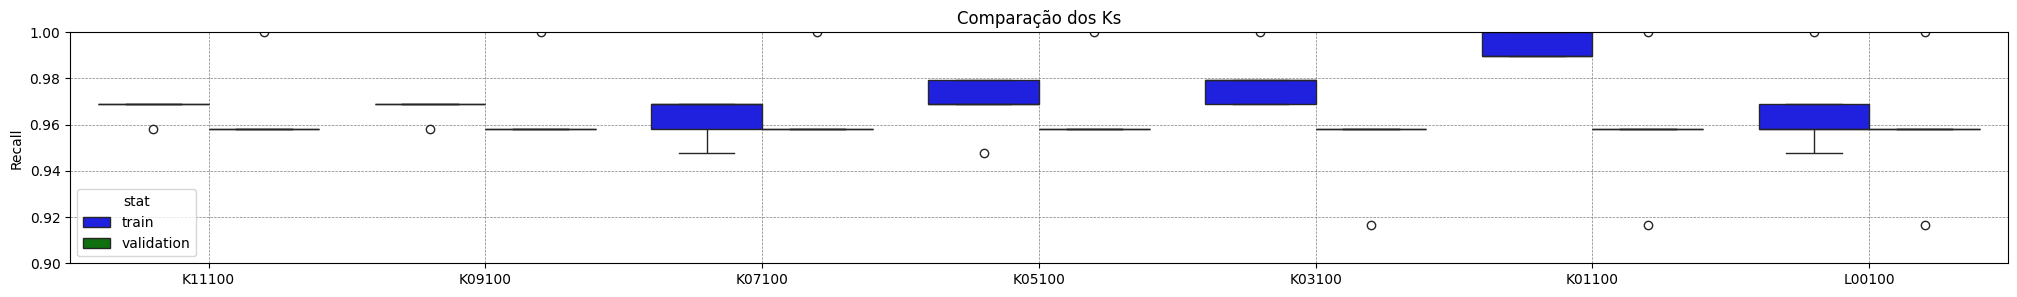

In [264]:
ix_db_size = results.db_size == 1.0
ix_evaluation_pick = results.metric == evaluation_pick
ix_results = ix_db_size & ix_evaluation_pick

fig = pyplot.figure(figsize=(25, 3))
ax = fig.add_subplot(111)
_ = seaborn.boxplot(x='hdb', y='metric_value', data=results.loc[ix_results, :], hue='stat', palette=['blue', 'green'], ax=ax, hue_order=['train', 'validation'])
ax.set_title('Comparação dos Ks')
ax.set_ylabel(f'{evaluation_pick.capitalize()}')
ax.set_xlabel('')
ax.set_ylim(0.9, 1.0)
ax.grid(which='both', color='gray', linestyle='--', linewidth=0.5)

### PICK DO MELHOR K

In [265]:
ix_validation = results["stat"] == "validation"
ix_knn = results["algorithm"] == "KNN"
ix_dbsize = results["db_size"] == 1.0
ix_evaluation_pick = results["metric"] == evaluation_pick
ix_best_k = ix_validation & ix_knn & ix_dbsize & ix_evaluation_pick

mean_metric_by_kf = results.loc[ix_best_k, ["hyperparameter", "hdb", "metric_value"]].groupby(["hyperparameter", "hdb"]).agg(["mean", "min"]).reset_index()
mean_metric_by_kf.columns = ['h', 'hdb', f'mean_{evaluation_pick}', f'min_{evaluation_pick}']
mean_metric_by_kf = mean_metric_by_kf.sort_values(by=['h', f'mean_{evaluation_pick}', f'min_{evaluation_pick}'], ascending=[False, False, False])
mean_metric_by_kf

,h,hdb,mean_recall,min_recall
5,11.0,K11100,0.966667,0.958333
4,9.0,K09100,0.966667,0.958333
3,7.0,K07100,0.966667,0.958333
2,5.0,K05100,0.966667,0.958333
1,3.0,K03100,0.950000,0.916667
0,1.0,K01100,0.958333,0.916667


In [266]:
results.loc[ix_validation & ix_knn & ix_dbsize, :].sort_values(by='metric_value')

,ix_model,algorithm,hyperparameter,db_size,hdb,fold,model_name,stat,metric,metric_value,scaler,model
5031,628,KNN,1.0,1.0,K01100,4,KNN-01-100-4,validation,f1_score,0.916667,StandardScaler(),"KNeighborsClassifier(metric='euclidean', n_nei..."
5029,628,KNN,1.0,1.0,K01100,4,KNN-01-100-4,validation,recall,0.916667,StandardScaler(),"KNeighborsClassifier(metric='euclidean', n_nei..."
5027,628,KNN,1.0,1.0,K01100,4,KNN-01-100-4,validation,precision,0.916667,StandardScaler(),"KNeighborsClassifier(metric='euclidean', n_nei..."
5025,628,KNN,1.0,1.0,K01100,4,KNN-01-100-4,validation,accuracy,0.916667,StandardScaler(),"KNeighborsClassifier(metric='euclidean', n_nei..."
5023,627,KNN,3.0,1.0,K03100,4,KNN-03-100-4,validation,f1_score,0.916667,StandardScaler(),"KNeighborsClassifier(metric='euclidean', n_nei..."
...,...,...,...,...,...,...,...,...,...,...,...,...
4807,600,KNN,1.0,1.0,K01100,0,KNN-01-100-0,validation,f1_score,1.000000,StandardScaler(),"KNeighborsClassifier(metric='euclidean', n_nei..."
4839,604,KNN,7.0,1.0,K07100,1,KNN-07-100-1,validation,f1_score,1.000000,StandardScaler(),"KNeighborsClassifier(metric='euclidean', n_nei..."
4837,604,KNN,7.0,1.0,K07100,1,KNN-07-100-1,validation,recall,1.000000,StandardScaler(),"KNeighborsClassifier(metric='euclidean', n_nei..."
4835,604,KNN,7.0,1.0,K07100,1,KNN-07-100-1,validation,precision,1.000000,StandardScaler(),"KNeighborsClassifier(metric='euclidean', n_nei..."


### RETREINO MELHOR K

In [267]:
best_k = mean_metric_by_kf.iloc[0, :]['h']
# RETRAIN MODEL WITH ALL TRAINING + VALIDATION
best_k_scaler = StandardScaler()
X_best_k_scaled = best_k_scaler.fit_transform(iris_train[x_cols])
y_best_k = iris_train['target']
best_k_knn = KNeighborsClassifier(n_neighbors=int(best_k), metric=distance_metric, weights=weights)
best_k_knn.fit(X_best_k_scaled, y_best_k)
y_best_k_pred = best_k_knn.predict(X_best_k_scaled)
match evaluation_pick:
    case 'accuracy':
        knn_retrain_metric = metrics_dict[evaluation_pick](y_best_k, y_best_k_pred)
    case _:
        knn_retrain_metric = metrics_dict[evaluation_pick](y_best_k, y_best_k_pred, average=evaluation_average)

print(f"Modelo KNN retreinado com K={best_k} @ {evaluation_pick} > treino: {100.0*knn_retrain_metric:.1f}%")

Modelo KNN retreinado com K=11.0 @ recall > treino: 96.7%


### RETREINO REGRESSÃO LOGÍSTICA

In [268]:
reg_log_scaler = StandardScaler()
X_reg_log_scaled = reg_log_scaler.fit_transform(iris_train[x_cols])
y_reg_log = iris_train['target']

retrain_logreg = LogisticRegression(penalty=None,
                                    dual=False,
                                    class_weight='balanced',
                                    random_state=random_seed,
                                    solver='lbfgs',
                                    max_iter=1000)
retrain_logreg.fit(X_reg_log_scaled, y_reg_log)
y_reg_log_pred = retrain_logreg.predict(X_reg_log_scaled)
match evaluation_pick:
    case 'accuracy':
        log_reg_retrain_metric = metrics_dict[evaluation_pick](y_reg_log, y_reg_log_pred)
    case _:
        log_reg_retrain_metric = metrics_dict[evaluation_pick](y_reg_log, y_reg_log_pred, average=evaluation_average)

print(f"Modelo LGR retreinado @ {evaluation_pick} > treino: {100.0*train_accuracy:.1f}%")

Modelo LGR retreinado @ recall > treino: 100.0%


### CANDIDATOS: RETREINOS + MELHOR FOLDS

In [269]:
# best_k_knn, retrain_logreg
ix_dbsize = results["db_size"] == 1.0
ix_knn = results["algorithm"] == "KNN"
ix_best_hyperparameter = results["hyperparameter"] == best_k
ix_validation = results["stat"] == "validation"
ix_evaluation_pick = results["metric"] == evaluation_pick
ix_best_k = ix_dbsize & ix_knn & ix_best_hyperparameter & ix_validation & ix_evaluation_pick

best_k_fold_row = results.loc[ix_best_k, :].sort_values(by='metric_value', ascending=False).iloc[0, :]
best_k_fold_scaler = best_k_fold_row['scaler']
best_k_fold_knn = best_k_fold_row['model']

best_k_fold_knn

KNeighborsClassifier(metric='euclidean', n_neighbors=11)

In [270]:
ix_dbsize = results["db_size"] == 1.0
ix_logreg = results["algorithm"] == "LGR"
ix_validation = results["stat"] == "validation"
ix_evaluation_pick = results["metric"] == evaluation_pick
ix_best_logreg = ix_dbsize & ix_logreg & ix_validation & ix_evaluation_pick

best_logreg_fold_row = results.loc[ix_best_logreg, :].sort_values(by='metric_value', ascending=False).iloc[0, :]
best_logreg_fold_scaler = best_logreg_fold_row['scaler']
best_logreg_fold_lgr = best_logreg_fold_row['model']

best_logreg_fold_lgr

LogisticRegression(class_weight='balanced', max_iter=1000, penalty=None,
                   random_state=42)

### ERRO HOLDOUT ERRO ALL PARA OS CANDIDATOS

In [271]:
candidate_models = [("KNN", "RETRAIN", best_k_scaler, best_k_knn), 
                    ("LGR", "RETRAIN", reg_log_scaler, retrain_logreg),
                    ("KNN", "FOLD", best_k_fold_scaler, best_k_fold_knn),
                    ("LGR", "FOLD", best_logreg_fold_scaler, best_logreg_fold_lgr)]

# CALCULATE HOLDOUT AND ALL ACCURACY
holdout_results = []
for algorithm, config, scaler, model in candidate_models:
    X_test_scaled = scaler.transform(iris_test[x_cols])
    y_test = iris_test['target']
    X_all_scaled = scaler.transform(iris[x_cols])
    y_all = iris['target']
    y_test_pred = model.predict(X_test_scaled)
    y_all_pred = model.predict(X_all_scaled)
    match evaluation_pick:
        case 'accuracy':
            test_metric = metrics_dict[evaluation_pick](y_test, y_test_pred)
            all_metric = metrics_dict[evaluation_pick](y_all, y_all_pred)
        case _:
            test_metric = metrics_dict[evaluation_pick](y_test, y_test_pred, average=evaluation_average)
            all_metric = metrics_dict[evaluation_pick](y_all, y_all_pred, average=evaluation_average)

    holdout_results.append({'algorithm': algorithm,
                            'config': config,
                            'stat': 'holdout',
                            'metric': evaluation_pick,
                            'metric_value': test_metric,
                            'model': model,
                            'scaler': scaler})
    holdout_results.append({'algorithm': algorithm,
                            'config': config,
                            'stat': 'all',
                            'metric': evaluation_pick,
                            'metric_value': all_metric,
                            'model': model,
                            'scaler': scaler})
    
holdout_results = pandas.DataFrame(holdout_results)
holdout_results = holdout_results.sort_values(by='metric_value', ascending=False)
holdout_results

,algorithm,config,stat,metric,metric_value,model,scaler
2,LGR,RETRAIN,holdout,recall,0.966667,"LogisticRegression(class_weight='balanced', ma...",StandardScaler()
6,LGR,FOLD,holdout,recall,0.966667,"LogisticRegression(class_weight='balanced', ma...",StandardScaler()
3,LGR,RETRAIN,all,recall,0.960000,"LogisticRegression(class_weight='balanced', ma...",StandardScaler()
1,KNN,RETRAIN,all,recall,0.960000,"KNeighborsClassifier(metric='euclidean', n_nei...",StandardScaler()
7,LGR,FOLD,all,recall,0.960000,"LogisticRegression(class_weight='balanced', ma...",StandardScaler()
5,KNN,FOLD,all,recall,0.960000,"KNeighborsClassifier(metric='euclidean', n_nei...",StandardScaler()
0,KNN,RETRAIN,holdout,recall,0.933333,"KNeighborsClassifier(metric='euclidean', n_nei...",StandardScaler()
4,KNN,FOLD,holdout,recall,0.933333,"KNeighborsClassifier(metric='euclidean', n_nei...",StandardScaler()


### PICK DO MELHOR MODELO

In [272]:
best_model_row = holdout_results.loc[holdout_results['stat'] == 'holdout', :].sort_values(by='metric_value', ascending=False).iloc[0, :]
best_model_row

algorithm                                                     LGR
config                                                    RETRAIN
stat                                                      holdout
metric                                                     recall
metric_value                                             0.966667
model           LogisticRegression(class_weight='balanced', ma...
scaler                                           StandardScaler()
Name: 2, dtype: object

In [273]:
best_model = best_model_row['model']
best_model_scaler = best_model_row['scaler']

print(f"Melhor modelo: {best_model_row['algorithm']} - {best_model_row['config']} > holdout: {100.0*best_model_row['metric_value']:.1f}%, all: {100.0*holdout_results.loc[holdout_results['stat'] == 'all', 'metric_value'].max():.1f}%")

Melhor modelo: LGR - RETRAIN > holdout: 96.7%, all: 96.0%


### Matriz de Confusão

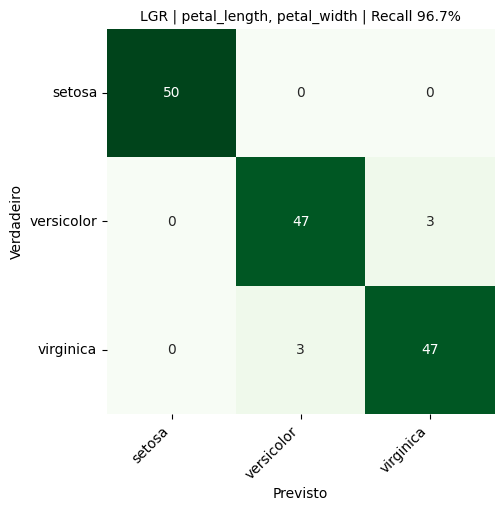

In [274]:
Xs = best_model_scaler.transform(iris[x_cols])
y = iris['target']
winner_y_pred = best_model.predict(Xs)

fig = pyplot.figure(figsize=(5, 5))
# PLOT CONFUSION MATRIX
conf_matrix = confusion_matrix(y, winner_y_pred)

ax = fig.add_subplot(111)
_ = seaborn.heatmap(conf_matrix, annot=True, cmap='Greens', cbar=False, ax=ax)
_ = ax.set_xlabel('Previsto')
_ = ax.set_ylabel('Verdadeiro')
_ = ax.set_xticklabels(iris['species'].unique(), rotation=45, ha='right')
_ = ax.set_yticklabels(iris['species'].unique(), rotation=0, ha='right')
# _ = ax.set_title(f'Vencedor: {winner.fk} | treino {100.0*winner_train_accuracy:.0f}% | teste {100.0*winner.hit:.0f}%')
best_feat_string = ', '.join(x_cols)
_ = ax.set_title(f'{best_model_row['algorithm']} | {best_feat_string} | {evaluation_pick.capitalize()} {100.0*best_model_row['metric_value']:.1f}%', size=10)

### SUPERFÍCIE DE SEPARAÇÃO

In [275]:
from itertools import product

In [276]:
# CLASS COLOR GRID & CLASS EVALUATION
grid_n_points = 50
little_delta = 0.1
jitter_factor = 0.1
rect_expansion = 1.1
species = iris['species'].unique().tolist()

# X0 W JITTER
X_plot = iris[x_cols].to_numpy()

x0_grid = numpy.linspace(0, rect_expansion*(X_plot[:, 0].max()), grid_n_points)
x0_jitter = jitter_factor*(x0_grid[1] - x0_grid[0])
x1_grid = numpy.linspace(0, rect_expansion*(X_plot[:, 1].max()), grid_n_points)
x1_jitter = jitter_factor*(x1_grid[1] - x1_grid[0])
X_g = numpy.array(list(product(x0_grid, x1_grid)))
X_g[:, 0] += x0_jitter*numpy.random.randn(X_g.shape[0])
X_g[:, 1] += x1_jitter*numpy.random.randn(X_g.shape[0])
X_g_scaled = StandardScaler().fit_transform(X_g)
Y_g = best_model.predict(X_g_scaled)
Y_g_class = numpy.array([species[x] for x in Y_g])
Y_est = best_model.predict(Xs)
Y_class_est = numpy.array([species[x] for x in Y_g])
# ix_missclass = iris['target'].to_numpy() != Y_class_est
# missclass = X_plot[ix_missclass]
# x_0_miss = missclass[:, 0]
# x_1_miss = missclass[:, 1]

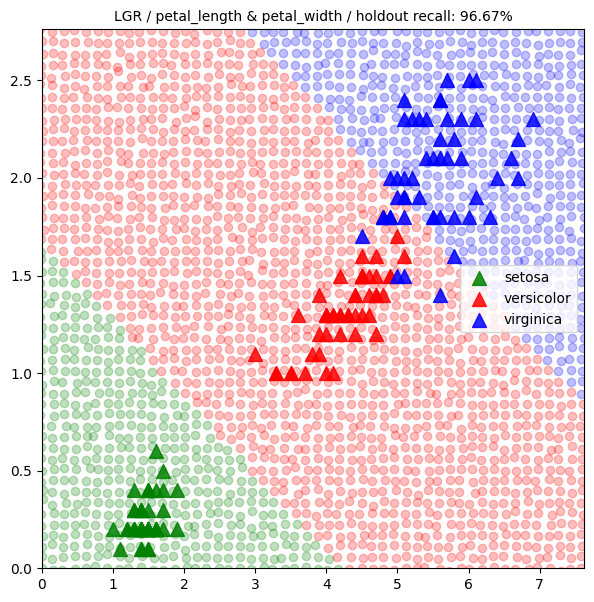

In [278]:
# CLASSIFICATION FIGURE
fig = pyplot.figure(figsize=(7, 7))
ax = fig.add_subplot(111)

color_list = ['green', 'red', 'blue', 'yellow']


# GIVE COLOURS TO CLASS
color_dict = {}
ix_color = 0
for specie in species:
    color_dict[specie] = color_list[ix_color]
    ix_color += 1

# PLOT CLASS REGION
for specie in species:
    ix_class_cloud = Y_g_class == specie
    x_0_cloud = X_g[ix_class_cloud, 0]
    x_1_cloud = X_g[ix_class_cloud, 1]
    _ = ax.scatter(x_0_cloud, x_1_cloud, marker='o', color=color_dict[specie], alpha=0.25)

# PLOR FLOWERS
for specie in species:
    ix_class = iris['species'] == specie
    x_0 = X_plot[ix_class, 0]
    x_1 = X_plot[ix_class, 1]
    _ = ax.scatter(x_0, x_1, color=color_dict[specie], marker='^', alpha=0.85, s=100, label=specie)
    _ = ax.legend()
_ = ax.set_xlim([0.0, X_g[:, 0].max()])
_ = ax.set_ylim([0.0, X_g[:, 1].max()])
_ = ax.set_title(f"{best_model_row['algorithm']} / {' & '.join(x_cols)} / holdout {best_model_row['metric']}: {100.0*best_model_row['metric_value']:.2f}%", size=10)

CONFUSÃO + ROC + SUPERFÍCIE DE SEPARAÇÃO MELHOR MODELO

LEARNING CURVE MELHOR K VS REGRESSÃO LOGÍSTICA

FLUTUAÇÃO DOS PARÂMETROS DA REGRESSÃO LOGÍSTICA